# Testing IL
In this notebook we will compare the IL of the implemented AMM to theory.


## Simulation Setup

In [1]:
import ipywidgets as widgets


class Seed:  # I know this looks dumb. not my fault
    random_seed = 1
    
print("Random Seed")
seed_input = widgets.IntText(
    value=Seed.random_seed,
    step=1,
    description='',
    disabled=False
)

output = widgets.Output()
display(seed_input, output)

def on_value_change(change):
    with output:
        Seed.random_seed = change['new']

seed_input.observe(on_value_change, names='value')

Random Seed


IntText(value=1)

Output()

In [2]:
# Dependencies
import pandas
from matplotlib import pyplot
from model.amm.amm import Asset, WorldState
from model.amm.omnipool_amm import OmnipoolAgent, OmniPool, OmnipoolTradeStrategies
import random
import math

# Experiments
from model import run, plot_utils, init_utils

random.seed(Seed.random_seed)

assets = [
    Asset(name='LRNA', price=0.4),
    Asset(name='HDX', price=0.08),
    Asset(name='USD', price=1),
    Asset(name='ETH', price=3000),
    Asset(name='DOGE', price=0.001)
]
omnipool = (
    OmniPool(
        tvl_cap_usd=100000000,
        lrna_fee=0.001,
        asset_fee=0.001,
        preferred_stablecoin='USD'
    )
    .add_lrna_pool('HDX', 1000000)
    .add_lrna_pool('USD', 100000)
    .add_lrna_pool('ETH', 1000)
    .add_lrna_pool('DOGE', 10000000)
)
agents = {
    "trader": OmnipoolAgent(
        name='trader',
        trade_strategy=OmnipoolTradeStrategies.random_swaps
    )
    .add_position('DOGE', 100000)
    .add_position('ETH', 10),
    
    "LP1": OmnipoolAgent(name='liquidity provider')
    .add_liquidity(omnipool, 'HDX', 10000)
    .add_liquidity(omnipool, 'ETH', 100),
    
    "LP2": OmnipoolAgent(name='liquidity provider')
    .add_liquidity(omnipool, 'DOGE', 1000000)
    .add_liquidity(omnipool, 'USD', 10000),
}

worldState = WorldState(
    exchange=omnipool,
    agents=agents
)

timesteps = 5000
state = {'WorldState': worldState}
config_dict = {
    'N': 1,  # number of monte carlo runs
    'T': range(timesteps),  # number of timesteps - 147439 is the length of uniswap_events
    'M': {'timesteps': [timesteps]},  # simulation parameters
}

pandas.options.mode.chained_assignment = None  # default='warn'
pandas.options.display.float_format = '{:.2f}'.format

run.config(config_dict, state)
events = run.run()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (5000, 1, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 1.90s


In [3]:
from model import processing
rdf, agent_df = processing.postprocessing(events, params_to_include=['withdraw_val', 'hold_val', 'pool_val'])


In [4]:
%matplotlib inline



In [5]:
rdf.head(20)  # Todo: delete

,timestep,L,simulation,substep,subset,run,R-0,R-1,R-2,R-3,...,Q-3,B-0,B-1,B-2,B-3,S-0,S-1,S-2,S-3,pool_val
1,1,0.00,0,1,0,1,1010000,110000,1100.00,11000000.00,...,27500.00,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6813.83
2,2,0.00,0,1,0,1,1010000,110000,1099.98,11049543.51,...,27376.70,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6814.04
3,3,0.00,0,1,0,1,1010000,110000,1099.98,11049543.51,...,27376.70,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6814.04
4,4,0.00,0,1,0,1,1010000,110000,1099.98,11054279.33,...,27364.97,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6814.06
5,5,0.00,0,1,0,1,1010000,110000,1104.32,5071138.43,...,59721.83,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6760.69
6,6,0.00,0,1,0,1,1010000,110000,1105.83,4268970.40,...,70957.31,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6742.21
7,7,0.00,0,1,0,1,1010000,110000,1105.83,4268970.40,...,70957.31,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6742.21
8,8,0.00,0,1,0,1,1010000,110000,1105.50,4421453.40,...,68510.20,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6746.22
9,9,0.00,0,1,0,1,1010000,110000,1108.59,3316993.52,...,91352.50,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6708.71
10,10,0.00,0,1,0,1,1010000,110000,1101.80,7423536.67,...,40818.23,1000000,100000,1000,10000000,1010000.00,110000.00,1100.00,11000000.00,6791.62


In [6]:
agent_df.head(20)  # TODO: delete

,simulation,subset,run,substep,timestep,q,agent_label,p-0,p-1,p-2,...,r-0,r-1,r-2,r-3,s-0,s-1,s-2,s-3,hold_val,withdraw_val
3,0,0,1,1,1,0,trader,0.00,0,0,...,0,0,10.00,100000.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0,0,1,1,1,0,LP1,0.08,0,3000,...,0,0,0.00,0.00,10000.00,0.00,100.00,0.00,752000.00,976854.83
5,0,0,1,1,1,0,LP2,0.00,1,0,...,0,0,0.00,0.00,0.00,10000.00,0.00,1000000.00,27500.00,35714.29
6,0,0,1,1,2,0,trader,0.00,0,0,...,0,0,10.02,50456.49,0.00,0.00,0.00,0.00,0.00,0.00
7,0,0,1,1,2,0,LP1,0.08,0,3000,...,0,0,0.00,0.00,10000.00,0.00,100.00,0.00,752011.20,976877.68
8,0,0,1,1,2,0,LP2,0.00,1,0,...,0,0,0.00,0.00,0.00,10000.00,0.00,1000000.00,27488.79,35691.41
9,0,0,1,1,3,0,trader,0.00,0,0,...,0,0,10.02,50456.49,0.00,0.00,0.00,0.00,0.00,0.00
10,0,0,1,1,3,0,LP1,0.08,0,3000,...,0,0,0.00,0.00,10000.00,0.00,100.00,0.00,752011.20,976877.68
11,0,0,1,1,3,0,LP2,0.00,1,0,...,0,0,0.00,0.00,0.00,10000.00,0.00,1000000.00,27488.79,35691.41
12,0,0,1,1,4,0,trader,0.00,0,0,...,0,0,10.02,45720.67,0.00,0.00,0.00,0.00,0.00,0.00


## Analysis

[0]


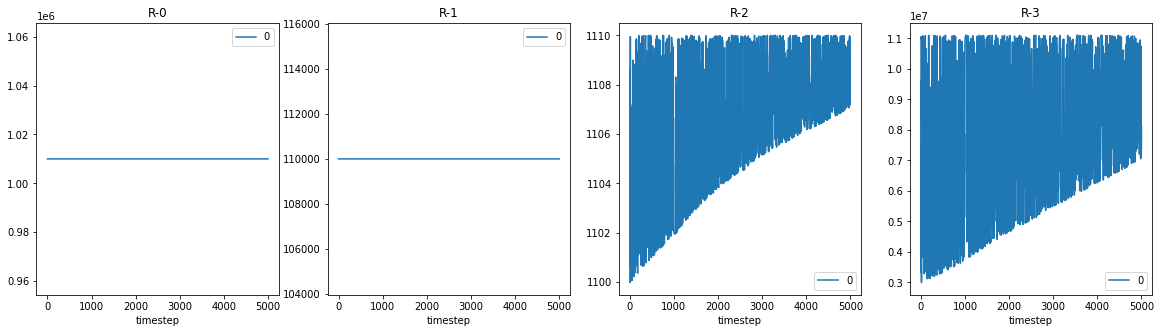

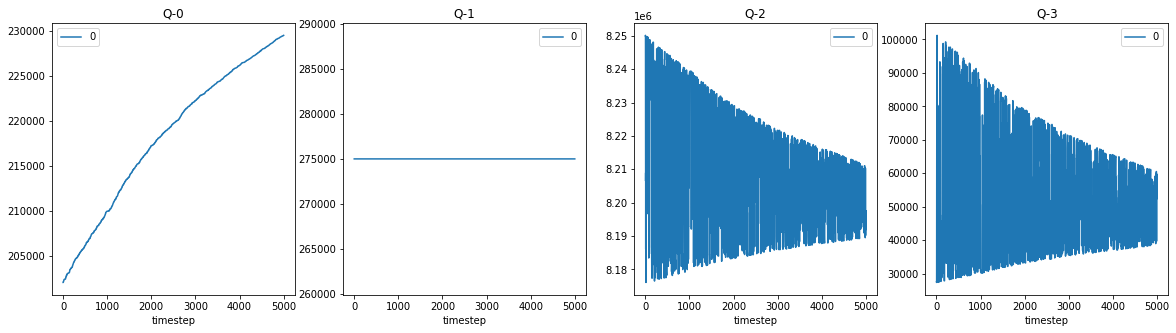

In [7]:
var_list = ['R', 'Q']
plot_utils.plot_vars(rdf, var_list)


[0]


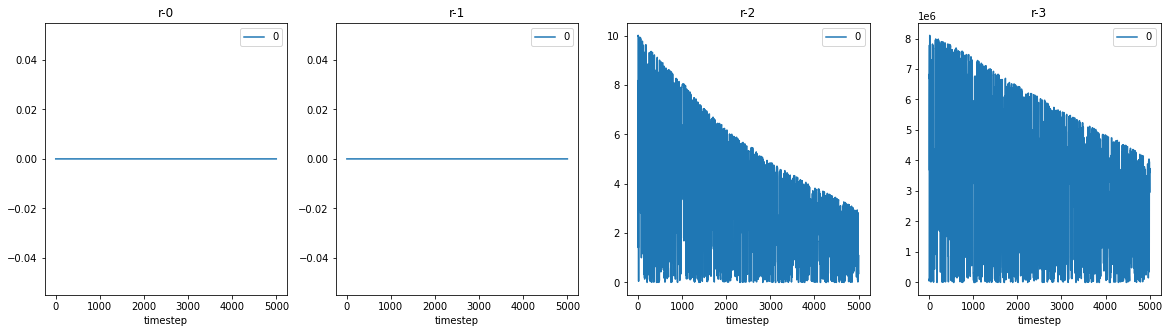

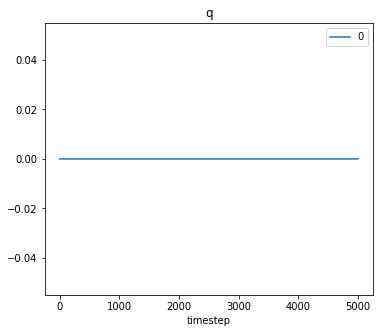

In [8]:
var_list = ['r', 'q']
trader_df = agent_df[agent_df['agent_label'] == 'trader']
plot_utils.plot_vars(trader_df, var_list)


In [9]:
# merge agent_df, rdf to one df on timesteps, run, etc

merged_df = pandas.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])

In [10]:
# add IL column to agent DF, where val_hold is calculated using initial holdings from agent_d
#val hold: withdraw liquidity at t=0, calculate value with prices at t
#val pool: withdraw liquidity at t, calculate value with prices at t


merged_df['P-0'] = merged_df.apply(lambda x: x['Q-0']/x['R-0'], axis=1)
merged_df['P-1'] = merged_df.apply(lambda x: x['Q-1']/x['R-1'], axis=1)

merged_df['IL'] = merged_df.apply(lambda x: x['withdraw_val']/x['hold_val'] - 1 if x['hold_val'] else 0, axis=1)
#merged_df['pool_loss'] = merged_df.apply(lambda x: x['pool_val']/2000000 - 1, axis=1)

merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','withdraw_val', 'hold_val','IL','pool_val', 'p-0']].tail()


# complot_utilste val hold column


# complot_utilste val pool column

# complot_utilste IL

# plot Impermanent loss
# 

,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,withdraw_val,hold_val,IL,pool_val,p-0
14995,4999,LP1,0,229522.54,1000000,10000.00,1010000.00,0,1010000,967166.23,747507.85,0.29,6716.34,0.08
14996,4999,LP2,0,229522.54,1000000,0.00,1010000.00,0,1010000,39960.88,29762.61,0.34,6716.34,0.00
14997,5000,trader,0,229528.05,1000000,0.00,1010000.00,0,1010000,0.00,0.00,0.00,6707.31,0.00
14998,5000,LP1,0,229528.05,1000000,10000.00,1010000.00,0,1010000,966143.84,747006.67,0.29,6707.31,0.08
14999,5000,LP2,0,229528.05,1000000,0.00,1010000.00,0,1010000,40955.73,30263.33,0.35,6707.31,0.00


In [11]:
merged_df[merged_df['agent_label'] == 'LP2'][['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','withdraw_val', 'hold_val','IL','pool_val']].head(20)


,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,withdraw_val,hold_val,IL,pool_val
2,1,LP2,0,202000.00,1000000,0.00,1010000.00,0,1010000,35714.29,27500.00,0.30,6813.83
5,2,LP2,0,202000.12,1000000,0.00,1010000.00,0,1010000,35691.41,27488.79,0.30,6814.04
8,3,LP2,0,202000.12,1000000,0.00,1010000.00,0,1010000,35691.41,27488.79,0.30,6814.04
11,4,LP2,0,202000.14,1000000,0.00,1010000.00,0,1010000,35689.24,27487.72,0.30,6814.06
14,5,LP2,0,202032.52,1000000,0.00,1010000.00,0,1010000,41566.31,30429.26,0.37,6760.69
17,6,LP2,0,202043.77,1000000,0.00,1010000.00,0,1010000,43530.44,31450.66,0.38,6742.21
20,7,LP2,0,202043.77,1000000,0.00,1010000.00,0,1010000,43530.44,31450.66,0.38,6742.21
23,8,LP2,0,202046.22,1000000,0.00,1010000.00,0,1010000,43105.02,31228.20,0.38,6746.22
26,9,LP2,0,202069.08,1000000,0.00,1010000.00,0,1010000,47038.07,33304.77,0.41,6708.71
29,10,LP2,0,202119.62,1000000,0.00,1010000.00,0,1010000,38176.13,28710.75,0.33,6791.62


In [12]:
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
LP1_merged_df[['timestep', 'agent_label', 'q','Q-0','B-0','s-0','S-0','r-0','R-0','withdraw_val', 'hold_val','IL','pool_val']].head(50)

,timestep,agent_label,q,Q-0,B-0,s-0,S-0,r-0,R-0,withdraw_val,hold_val,IL,pool_val
1,1,LP1,0,202000.00,1000000,10000.00,1010000.00,0,1010000,976854.83,752000.00,0.30,6813.83
4,2,LP1,0,202000.12,1000000,10000.00,1010000.00,0,1010000,976877.68,752011.20,0.30,6814.04
7,3,LP1,0,202000.12,1000000,10000.00,1010000.00,0,1010000,976877.68,752011.20,0.30,6814.04
10,4,LP1,0,202000.14,1000000,10000.00,1010000.00,0,1010000,976879.85,752012.26,0.30,6814.06
13,5,LP1,0,202032.52,1000000,10000.00,1010000.00,0,1010000,970871.92,749068.11,0.30,6760.69
16,6,LP1,0,202043.77,1000000,10000.00,1010000.00,0,1010000,968786.04,748045.79,0.30,6742.21
19,7,LP1,0,202043.77,1000000,10000.00,1010000.00,0,1010000,968786.04,748045.79,0.30,6742.21
22,8,LP1,0,202046.22,1000000,10000.00,1010000.00,0,1010000,969239.43,748268.06,0.30,6746.22
25,9,LP1,0,202069.08,1000000,10000.00,1010000.00,0,1010000,964999.16,746189.63,0.29,6708.71
28,10,LP1,0,202119.62,1000000,10000.00,1010000.00,0,1010000,974362.18,750779.56,0.30,6791.62


## IL over time



[0]


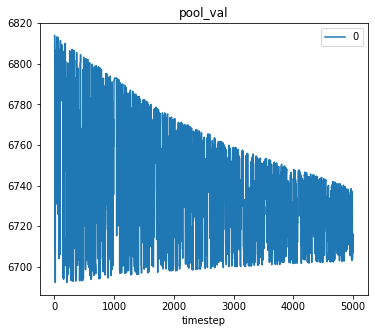

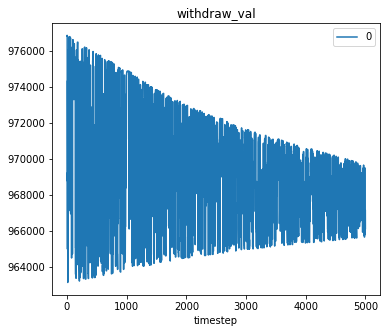

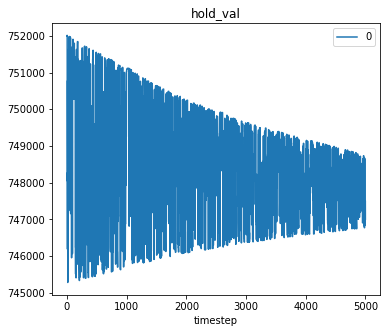

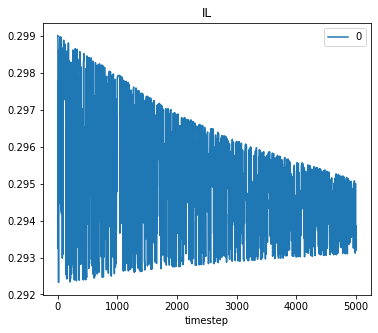

In [13]:
var_list = ['pool_val', 'withdraw_val', 'hold_val', 'IL']
LP1_merged_df = merged_df[merged_df['agent_label'] == 'LP1']
plot_utils.plot_vars(LP1_merged_df, var_list)

## IL as a function of price movement

### Theory

On a price move from $p_i^Q \to k p_i^Q$, LP is entitled to $k\frac{\sqrt{k}}{k+1}$ of the *original value* of the matched pool.
$$
Val_{hold} = k p_i^Q R_i\\
Val_{pool} = \frac{\sqrt{k}k}{k+1} 2Q_i = \left(\frac{2\sqrt{k}k}{k+1}\right) p_i^Q R_i
$$

### $Val_{hold}$

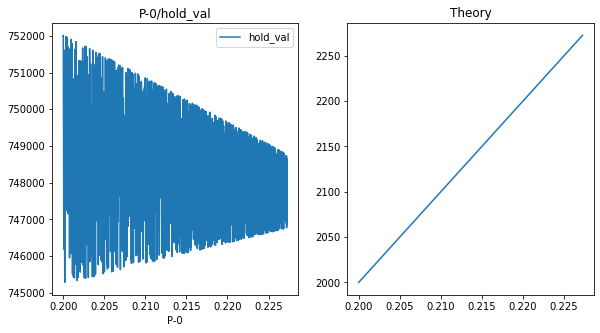

In [30]:
def val_hold_func(P, R):
    return P * R

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = pyplot.subplot(131, title='P-0/hold_val')
LP1_merged_df[['hold_val','P-0']].astype(float).plot(ax=ax, y=['hold_val'], x='P-0', label=[])

ax2 = pyplot.subplot(132, title='Theory')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: val_hold_func(x['P-0'], agents['LP1'].s('HDX')), axis=1)
ax2.plot(x,y)

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### $Val_{Pool}$

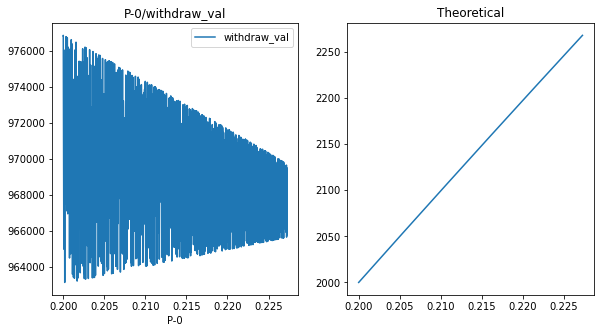

In [35]:
import math
def val_pool_func(P, P_init, R):
    k = P/P_init
    return 2 * k * math.sqrt(k) / (k + 1) * P_init * R

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = pyplot.subplot(131, title='P-0/withdraw_val')
LP1_merged_df[['withdraw_val','P-0']].astype(float).plot(ax=ax, y=['withdraw_val'], x='P-0', label=[])

ax2 = pyplot.subplot(132, title='Theoretical')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], omnipool.P('HDX'), agents['LP1'].s('HDX')), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], initial_values['P'][0], x['R-0']), axis=1)
ax2.plot(x, y, label='Theory')

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

### Impermanent Loss

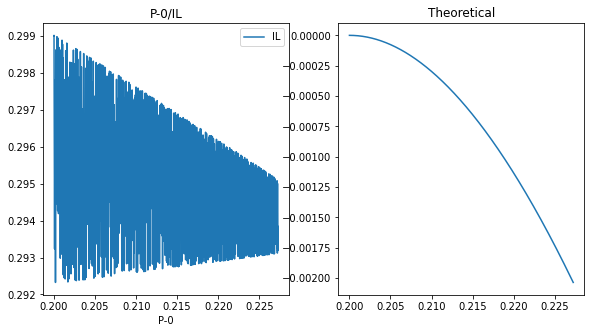

In [38]:
def IL_func(P, P_init, R):
    return val_pool_func(P, P_init, R)/val_hold_func(P, R) - 1

pyplot.figure(figsize=(15,5))

#ax = pyplot.subplot(131, title='P-0/IL')
#LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])
ax = pyplot.subplot(131, title='P-0/IL')
LP1_merged_df[['IL','P-0']].astype(float).plot(ax=ax, y=['IL'], x='P-0', label=[])

ax2 = pyplot.subplot(132, title='Theoretical')
x = LP1_merged_df['P-0'].tolist()
y = LP1_merged_df.apply(lambda x: IL_func(x['P-0'], omnipool.P('HDX'), agents['LP1'].s('HDX')), axis=1)
#y = LP1_merged_df.apply(lambda x: val_pool_func(x['P-0'], initial_values['P'][0], x['R-0']), axis=1)
ax2.plot(x, y, label='Theory')

#ax = pyplot.subplot(132, title='Theoretical')
#x = LP1_merged_df['P-0'].tolist()
#y = LP1_merged_df['P-0'].apply(lambda x: IL_func(x, 2, 0.5))
#ax.plot(x,y, label='Theory')

In [ ]:
LP1_merged_df[['val_pool', 'val_hold', 'R-0', 's-0', 'S-0', 'B-0', 'P-0', 'p-0']].tail()